# Running TCAV

This notebook walks you through an example application of the TCAV library step-by-step to understand which human interpretable concepts (e.g. stripes, dots, zigzags) are important to the image classifier GoogleNet's (a.k.a. Inception v1) prediction of Zebras.

## Install required packages

To run through this notebook in the interim, you are encouraged to utilize a `virtualenv` or `conda` environment for installing and working with the required packages to avoid any dependency and compatability issues with different versions of packages.

In [ ]:
%pip install tcav

## Download example models and images

Open a terminal and run the following commands:

```
cd tcav/tcav_examples/image_models/imagenet

python download_and_make_datasets.py --source_dir=YOUR_PATH --number_of_images_per_folder=50 --number_of_random_folders=3
```

This script will download the following content into separate folders into a directory you specify with the `--source_dir=` argument:

**Images**
*  ImageNet images for the target Zebra class
*  [Broden dataset](http://netdissect.csail.mit.edu/) images for three concepts (e.g. striped, dotted, zigzagged)
*  Random ImageNet class images used by TCAV for hypothesis testing of important concepts

**Models**
*  [Inception 5h model](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/inception5h.py)
*  [Mobilenet V2 model](https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet_v1.md)

## Import extensions and libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
import json

from torchvision import models

from tcav.model import ModelWrapper
from tcav.dataset import JsonDataset
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib

Using cuda device: 0
Using cuda device: 0


## TCAV step-by-step

You will walk through the following steps below:

1. **Store example images in each folder** (you have this if you ran the above)
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **Write a model wrapper** (below uses example from tcav/model.py)
 * an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **Retrieve model activations** (below uses example from tcav/activation_generator.py)
 * an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model
4. Run TCAV and visualize scores for important concepts.

## Step 1: Store concept and target class images to local folders

... and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 

You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [125]:
print ('REMEMBER TO UPDATE YOUR_PATH (where images, models are)!')

# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'ResNet50'
user = 'angus'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_zebra_test'
working_dir = Path("/tmp/" + user + '/' + project_name)
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir / 'activations'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir / 'cavs'
grad_dir = working_dir / "grads"
# where the images live.

# TODO: replace 'YOUR_PATH' with path to downloaded models and images.
source_dir = Path('/home/lina3782/labs/explain/imagenet')
bottlenecks = ["layer2.1", "layer2.2", "layer3.3", "layer3.4", "layer3.5", "layer4.0", 'layer4.1', "layer4.2"]  # @param
bottlenecks = {bn:bn for bn in bottlenecks}

for d in [activation_dir, working_dir, cav_dir, grad_dir]:
    d.mkdir(exist_ok=True, parents=True)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

num_random_exp = 30
target = 'leopard'
concepts = ["polka", "flecked", "dotted", "striped", "lined", "banded", "zigzagged"]


REMEMBER TO UPDATE YOUR_PATH (where images, models are)!


## Step 2: Write your model wrapper

The next step is to tell TCAV how to communicate with your model. See `model.GoogleNetWrapper_public ` for details.

You can define a subclass of ModelWrapper abstract class to do this. Let me walk you thru what each function does (tho they are pretty self-explanatory).  This wrapper includes a lot of the functions that you already have, for example, `get_prediction`.

### 2.1: Tensors from the graph: bottleneck tensors and ends
First, store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. You only need bottlenecks that you are interested in running TCAV with. Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2.2: Define loss
Get your loss tensor, and assigned it to `self.loss`. This is what TCAV uses to take directional derivatives. 

While doing so, you would also want to set 
```python
self.y_input 
```
this simply is a tensorflow place holder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat).
For multi-class classification, typically something like this works:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

For example, for a multiclass classifier, something like below would work. 

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 2.3: Call _make_gradient_tensors in __init__() of your wrapper
```python
_make_gradient_tensors()  
```
does what you expect - given the loss and bottleneck tensors defined above, it adds gradient tensors.

### 2.4: Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format.

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

Set your input image shape at  `self.image_shape`


Set your model name to `self.model_name`

You are done with writing the model wrapper! See the two example model wrapers, InceptionV3 and Googlenet in `tcav/model.py`.

In [126]:
def create_model():
    return models.resnet50(pretrained=True)

In [127]:

# model_path is where the trained model is stored.
#model_path = source_dir / "/inception5h/example_model.pt"
model = create_model()
#model = model.load_state(model_path)

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...
label_path = source_dir / "class_names.txt"
with open(label_path, "r") as fp:
    class_names = fp.read()
class_names = class_names.split("\n")
class_names_short = [v.split(",")[0] for v in class_names]
mymodel = ModelWrapper(model, bottlenecks, class_names_short)

In [128]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [129]:
class_names

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [130]:
class_names_short

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [132]:
mymodel.label_to_id(target)

288

## Step 3: Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [133]:
data_path = source_dir / "data"

source_json = {}
for concept in [target] + concepts + [f"random500_{i}" for i in range(num_random_exp)]:
    paths = (data_path / concept).glob("*.jpg")
    source_json[concept] = {i: {"path": f"{concept}/{path.name}", "label": 0} for i, path in enumerate(paths)}

source_json_path = source_dir / "example_source_json.json"
with open(source_json_path, "w") as fp:
    json.dump(source_json, fp, indent=2)

source_json

{'leopard': {0: {'path': 'leopard/cat_leopard2.jpg', 'label': 0},
  1: {'path': 'leopard/Jaguar_060405_3074.jpg', 'label': 0},
  2: {'path': 'leopard/LEOP_03M.jpg', 'label': 0},
  3: {'path': 'leopard/leopard_72.jpg', 'label': 0},
  4: {'path': 'leopard/panthe11.jpg', 'label': 0},
  5: {'path': 'leopard/Leopard%20in%20tree.jpg', 'label': 0},
  6: {'path': 'leopard/ME_Kenya_04_Q2H2609.jpg', 'label': 0},
  7: {'path': 'leopard/son_panter_web.jpg', 'label': 0},
  8: {'path': 'leopard/10-21.jpg', 'label': 0},
  9: {'path': 'leopard/NS_leopard1.jpg', 'label': 0},
  10: {'path': 'leopard/07881.jpg', 'label': 0},
  11: {'path': 'leopard/ME_Kenya_04_Q2H2687.jpg', 'label': 0},
  12: {'path': 'leopard/marozi3.jpg', 'label': 0},
  13: {'path': 'leopard/levhart_3.jpg', 'label': 0},
  14: {'path': 'leopard/Leopardo.jpg', 'label': 0},
  15: {'path': 'leopard/ME_Kenya_04_Q2H2435.jpg', 'label': 0},
  16: {'path': 'leopard/300px-Leopard.jpg', 'label': 0},
  17: {'path': 'leopard/LEOP_04M.jpg', 'label':

concept_dict = {
    "concept1": {"0": {"path": "dasd", "label": "asd"}, "1": {}},
    "concept2": {},
    "random500_0": {},
    "random500_1": {}
}

In [134]:
max_examples = 100
prefix = str(data_path) + "/"
num_workers = 4

act_generator = act_gen.ActivationGenerator(mymodel, source_json_path, activation_dir, JsonDataset, max_examples=max_examples, prefix=prefix, num_workers=4)

In [135]:
example_dataset = JsonDataset(source_json, target, prefix)
example_dataset[0]

{'id': 0,
 'img': tensor([[[ 1.4954,  1.5175,  1.5507,  ...,  1.4129,  1.4269,  1.4269],
          [ 1.5385,  1.5606,  1.5938,  ...,  1.3927,  1.4125,  1.4125],
          [ 1.5969,  1.6190,  1.6471,  ...,  1.3159,  1.3471,  1.3471],
          ...,
          [ 1.5135,  1.3095,  1.1548,  ...,  0.6675,  0.5030,  0.4007],
          [ 1.2462,  1.1099,  0.9877,  ...,  0.6922,  0.5448,  0.4343],
          [ 0.5707,  0.7032,  0.8112,  ...,  0.5473,  0.4585,  0.3481]],
 
         [[ 1.4132,  1.4358,  1.4696,  ...,  1.2063,  1.2206,  1.2206],
          [ 1.4572,  1.4798,  1.5137,  ...,  1.1856,  1.2059,  1.2059],
          [ 1.4913,  1.5139,  1.5373,  ...,  1.0943,  1.1262,  1.1262],
          ...,
          [ 1.1690,  0.9696,  0.8321,  ...,  0.4921,  0.3239,  0.2193],
          [ 0.9042,  0.7933,  0.6840,  ...,  0.5045,  0.3538,  0.2408],
          [ 0.2577,  0.3932,  0.5035,  ...,  0.3563,  0.2656,  0.1527]],
 
         [[ 0.8099,  0.8324,  0.8804,  ...,  0.6040,  0.6182,  0.6182],
          [

## Step 4: Run TCAV and visualize concept importance

You are now ready to run TCAV! Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores.


In [136]:
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs.

mytcav = tcav.TCAV(
    target,
    concepts,
    bottlenecks,
    act_generator,
    alphas,
    cav_dir=cav_dir,
    num_random_exp=num_random_exp,
    do_random_pairs=True,
    grad_dir=grad_dir
)

layer2.1 ['polka', 'random500_0'] leopard 0.1
layer2.1 ['polka', 'random500_1'] leopard 0.1
layer2.1 ['polka', 'random500_2'] leopard 0.1
layer2.1 ['polka', 'random500_3'] leopard 0.1
layer2.1 ['polka', 'random500_4'] leopard 0.1
layer2.1 ['polka', 'random500_5'] leopard 0.1
layer2.1 ['polka', 'random500_6'] leopard 0.1
layer2.1 ['polka', 'random500_7'] leopard 0.1
layer2.1 ['polka', 'random500_8'] leopard 0.1
layer2.1 ['polka', 'random500_9'] leopard 0.1
layer2.1 ['polka', 'random500_10'] leopard 0.1
layer2.1 ['polka', 'random500_11'] leopard 0.1
layer2.1 ['polka', 'random500_12'] leopard 0.1
layer2.1 ['polka', 'random500_13'] leopard 0.1
layer2.1 ['polka', 'random500_14'] leopard 0.1
layer2.1 ['polka', 'random500_15'] leopard 0.1
layer2.1 ['polka', 'random500_16'] leopard 0.1
layer2.1 ['polka', 'random500_17'] leopard 0.1
layer2.1 ['polka', 'random500_18'] leopard 0.1
layer2.1 ['polka', 'random500_19'] leopard 0.1
layer2.1 ['polka', 'random500_20'] leopard 0.1
layer2.1 ['polka', 'ran

In [ ]:
print("Training CAVs...")
mytcav.train_cavs(overwrite=False)


Training CAVs...
Training CAV ['polka', 'random500_0'] - layer2.1 alpha 0.1
training with alpha=0.1
CAV accuracies: {'polka': 0.8787878787878788, 'random500_0': 0.9705882352941176, 'overall': 0.9253731343283582}
Finished training polka-random500_0-layer2.1-linear-0.1 (6.4 s)
Training CAV ['polka', 'random500_0'] - layer2.2 alpha 0.1
training with alpha=0.1
CAV accuracies: {'polka': 1.0, 'random500_0': 0.9705882352941176, 'overall': 0.9850746268656716}
Finished training polka-random500_0-layer2.2-linear-0.1 (8.0 s)
CAV already exists: /tmp/angus/tcav_zebra_test/cavs/polka-random500_0-layer3.3-linear-0.1.pkl
CAV accuracies: {'polka': 0.9393939393939394, 'random500_0': 1.0, 'overall': 0.9701492537313433}
Finished training polka-random500_0-layer3.3-linear-0.1 (8.0 s)
CAV already exists: /tmp/angus/tcav_zebra_test/cavs/polka-random500_0-layer3.4-linear-0.1.pkl
CAV accuracies: {'polka': 1.0, 'random500_0': 1.0, 'overall': 1.0}
Finished training polka-random500_0-layer3.4-linear-0.1 (8.1 s)


In [123]:
print ('This may take a while... Go get coffee!')
results = mytcav.run(overwrite=False)
print ('done!')

This may take a while... Go get coffee!
Running 6480 params
Running param 0 of 6480
Running leopard ['polka', 'random500_0']
Running param 1 of 6480
Running leopard ['polka', 'random500_1']
Running param 2 of 6480
Running leopard ['polka', 'random500_2']
Running param 3 of 6480
Running leopard ['polka', 'random500_3']
Running param 4 of 6480
Running leopard ['polka', 'random500_4']
Running param 5 of 6480
Running leopard ['polka', 'random500_5']
Running param 6 of 6480
Running leopard ['polka', 'random500_6']
Running param 7 of 6480
Running leopard ['polka', 'random500_7']
Running param 8 of 6480
Running leopard ['polka', 'random500_8']
Running param 9 of 6480
Running leopard ['polka', 'random500_9']
Running param 10 of 6480
Running leopard ['polka', 'random500_10']
Running param 11 of 6480
Running leopard ['polka', 'random500_11']
Running param 12 of 6480
Running leopard ['polka', 'random500_12']
Running param 13 of 6480
Running leopard ['polka', 'random500_13']
Running param 14 of 64

Class = leopard
  Concept = polka
    Bottleneck = layer3.3. TCAV Score = 0.51 (+- 0.09), random was 0.50 (+- 0.12). p-val = 0.690 (not significant)
    Bottleneck = layer3.4. TCAV Score = 0.52 (+- 0.11), random was 0.51 (+- 0.13). p-val = 0.575 (not significant)
    Bottleneck = layer3.5. TCAV Score = 0.15 (+- 0.12), random was 0.50 (+- 0.20). p-val = 0.000 (significant)
    Bottleneck = layer4.0. TCAV Score = 0.35 (+- 0.23), random was 0.49 (+- 0.26). p-val = 0.002 (significant)
    Bottleneck = layer4.1. TCAV Score = 0.54 (+- 0.33), random was 0.51 (+- 0.42). p-val = 0.672 (not significant)
    Bottleneck = layer4.2. TCAV Score = 0.93 (+- 0.25), random was 0.51 (+- 0.50). p-val = 0.000 (significant)
  Concept = flecked
    Bottleneck = layer3.3. TCAV Score = 0.61 (+- 0.12), random was 0.50 (+- 0.12). p-val = 0.000 (significant)
    Bottleneck = layer3.4. TCAV Score = 0.59 (+- 0.11), random was 0.51 (+- 0.13). p-val = 0.001 (significant)
    Bottleneck = layer3.5. TCAV Score = 0.24 (

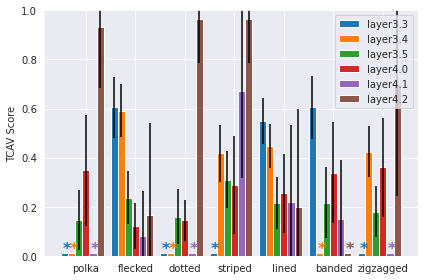

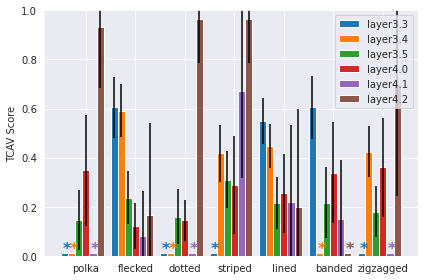

In [124]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

In [61]:
results_dir = source_dir / f"results/{target}"
results_dir.mkdir(parents=True, exist_ok=True)

In [62]:
exp_name = "33-34-35-40-41-42_100.json"
with open(results_dir / f"{exp_name}.json", "w") as fp:
    json.dump(results, fp, indent=2)